In [ ]:
# 데이터 및 모델 관련 라이브러리
import kagglehub
import pandas as pd
import os
import cv2
import xml.etree.ElementTree as ET

# 시각화 및 그래픽 관련 라이브러리
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# 데이터 로딩 및 변환 관련 라이브러리
from tqdm import tqdm
from torchvision.transforms import v2
from torchvision.transforms import functional as F

# PyTorch 관련 라이브러리
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

# 데이터 분할 관련 라이브러리
from sklearn.model_selection import train_test_split

# 기타
import time
import random
import warnings

warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive

# 드라이브 마운트
drive.mount('/content/drive')

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Mounted at /content/drive
cuda


- 미션 소개
    1. 이번 미션에서는 SSD 모델을 활용하여 개와 고양이의 얼굴(Face) 영역을 감지하는 Object Detection 작업을 수행해 봅시다.

- 데이터 소개
    1. 데이터 링크(The Oxford-IIIT Pet Dataset) - https://www.kaggle.com/datasets/devdgohil/the-oxfordiiit-pet-dataset/data
    2. annotations(xml): 각 이미지 파일에 대한 annotation
    3. images: 이미지 파일(37종의 개와 고양이)

- 제출 안내
    1. 분석 과정과 결과:
        - 데이터 로드, 전처리, 모델 학습, 예측, 성능 평가 등의 모든 과정을 포함해야 합니다.
        - Bounding Box에 대한 정보를 활용하여 SSD 모델을 활용한 Object Detection을 수행해 보세요.
    2. 마크다운을 활용한 설명
        - 코드의 각 단계에서 어떤 작업을 수행하는지, 어떤 의도를 가지고 접근했는지 명확히 표현할 수 있도록 마크다운을 적극 활용해 주세요.
        - 코드와 실행 결과를 설명하는 문구를 추가하여, 전체 코드의 흐름을 이해할 수 있도록 작성해 주세요. 보고서를 따로 작성하지 않으므로, 노트북 파일 내에 모든 설명이 잘 드러나야 합니다.
    3. 모델 성능 평가 및 제출
        - 평가 지표(mAP, IOU 등)를 활용해 모델 성능을 분석하고 비교해 보세요.
        - 제공된 데이터셋의 테스트 파일을 사용하여 모델을 테스트해 보세요.
        - 모델별 성능 평가 결과를 포함한 노트북 파일을 제출하세요.

- 참고 사항
    1. 미션을 시작할 때 도움이 필요하다면, Baseline 코드를 참고할 수 있습니다. 이 코드는 기본적인 코드로 제공되며, 여러분이 원하는 대로 자유롭게 변형할 수 있어요.
    2. 주의 사항: Baseline 코드는 여러분이 모델을 시작하는 데 도움을 주기 위한 참고 자료일 뿐이며, Baseline 코드를 그대로 사용하는 것보다는 이를 기반으로 자신의 아이디어를 추가하고 발전시키는 것이 중요합니다. 가능하면 스스로 모델을 구축해보고 다양한 방법을 시도하여 성능을 향상시켜 보세요.

The Oxford-IIIT Pet Dataset

- About Dataset
    1. Context
        - The Oxford-IIIT Pet Dataset is a 37 category pet dataset with roughly 100 images for each class created by the Visual Geometry Group at Oxford. The images have large variations in scale, pose and lighting. All images have an associated ground truth annotation of the breed, head ROI, and pixel level trimap segmentation.

    2. Inspiration
        - This dataset is useful for those who are new to Semantic segmentation, Object localization and Object detection as this data is very well formatted. Anyone can do Semantic segmentation, Object localization and Object detection using this dataset.

    3. Citation
        - Cats and Dogs

# 0.연구 방법 및 결론

0. 캐글(https://www.kaggle.com/code/youngsunjoung/object-detection-of-the-oxford-iiit-pet-pytorch)

1. SSD(Single Shot Detector) w/ Backbone(Resnet34)
    - SSD300을 사용한 이유는 SSD512보다 빠르고 메모리 사용량이 적다.
    이번에 사용하는 Oxford-IIIT Pet Dataset은 작은 객체가 아니며 이미지 내에서 한 개의 객체를(딱 한 이미지만 두 개의 객체가 존재한다.) 탐지하는데 적절한 성능을 가지고 있기 때문이다.
    백본으로 Resnet34를 사용한 이유는 가볍고 빠르며 SSD에 적절하기 때문이다. 또한 Skip Connection구조로 효과적으로 학습이 가능하기 때문이다.

2. 전처리
    1. 트랜스폼 : 바운딩 박스가 변하기에 최대한 건드리지 않았다. 밝기대비, 흑백변환, 색상반전, 가우시안 블러, 정규화 정도만 진행했다.

    2. 학습 : 검증 : 시험 = 367 : 92 : 459 크기로 나누었다.

    3. 모델 : SSD300의 구조를 그대로 사용하여 분류기만 3(고양이, 개, 배경)으로 맞추었다.

    4. 하이퍼 파라미터
        - optimizer : SGD w/ lr=0.001, momentum=0.9, weight_decay=0.0005
        - scheduler : CyclicLR w/ base_lr=0.00005, step_size_up=6, max_lr=0.001, gamma=0.75, mode='exp_range'
        - epochs = 30
        (러닝 스케쥴러를 여러개 사용했을때 가장 효과가 좋았다. 캐글에 실험한 결과가 있다.)

3. 훈련
    1. mAP가 증가할때만 모델을 저장
        - mAP 점수 0.97정도에서 학습이 멈췄다.
    
    2. No Bounding Boxes
        - 수치가 꽤 높음에도 불구하고 바운딩 박스가 없는 경우도 많았다. 로스가 감소하는 정도를 보면 클래스는 무척 잘 구분하며 위치도 정확해보이는데, 임계값이 0.5라서 영향을 주었을 것 같다.

4. 결론 : 여러번 실험을 했음에도 바운딩 박스가 아예 없거나 임계값을 넘지 못해서 예측이 실패한 경우가 많다. mAP 점수는 1과 차이가 0.03도 채 되지 않는데 이런 결과가 나온 것이 매우 신기하다. 랜덤하게 샘플을 뽑아서 이미지를 시각화했는데 이정도라면 분명히 더 발전할 가능성이 있어보인다. 더 배워봐야할 점이 많은 과제였다.

# 1.데이터 살펴보기

## 데이터 불러오기

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zippyz/cats-and-dogs-breeds-classification-oxford-dataset/versions/1")

# Download in kaggle
# path = "/kaggle/input/cats-and-dogs-breeds-classification-oxford-dataset"

print("Path to dataset files:", path)

100%|██████████| 780M/780M [00:09<00:00, 89.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zippyz/cats-and-dogs-breeds-classification-oxford-dataset/versions/1


In [ ]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

# 파일 경로 설정
trainval_file_path = os.path.join(path, "annotations", "annotations", "trainval.txt")
test_file_path = os.path.join(path, "annotations", "annotations", "test.txt")

# 이미지, Annotation 경로 설정
image_dir = os.path.join(path, "images", "images")
xml_dir = os.path.join(path, "annotations", "annotations", "xmls")

# Train/Validation 파일 읽기
df_trainval = pd.read_csv(trainval_file_path, sep="\s+", header=None)
df_trainval.columns = ["Image", "ClassID", "Species", "BreedID"]

# Test 파일 읽기
df_test = pd.read_csv(test_file_path, sep="\s+", header=None)
df_test.columns = ["Image", "ClassID", "Species", "BreedID"]

# 데이터 크기 확인
print(f"Train/Validation 데이터 수: {len(df_trainval)}")
print(f"Test 데이터 수: {len(df_test)}")

# Annotation 개수 확인
xml_files = [file for file in os.listdir(xml_dir) if file.endswith(".xml")]
print(f"XML 파일 개수: {len(xml_files)}")

Train/Validation 데이터 수: 3680
Test 데이터 수: 3669
XML 파일 개수: 3686


### 데이터 확인하기

In [ ]:
# 학습검증 데이터프레임
print(df_trainval.shape)
df_trainval.head()

(3680, 4)


,Image,ClassID,Species,BreedID
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [ ]:
# 시험 데이터프레임
print(df_test.shape)
df_test.head()

(3669, 4)


,Image,ClassID,Species,BreedID
0,Abyssinian_201,1,1,1
1,Abyssinian_202,1,1,1
2,Abyssinian_204,1,1,1
3,Abyssinian_205,1,1,1
4,Abyssinian_206,1,1,1


## 결측값(없음)

In [ ]:
# 학습검증 결측값
df_trainval.isna().sum()

,0
Image,0
ClassID,0
Species,0
BreedID,0


In [ ]:
# 시험 결측값
df_test.isna().sum()

,0
Image,0
ClassID,0
Species,0
BreedID,0


## 중복값(없음)

In [ ]:
# 학습검증 중복값
df_trainval.duplicated().sum()

0

In [ ]:
# 시험 중복값
df_test.duplicated().sum()

0

## 데이터 분포 시각화

In [ ]:
import matplotlib.pyplot as plt

# 컬럼별 시각화
def visualize_column_distribution(df, column_name):
    # 이미지 컬럼 패스(1개씩 있으므로)
    if column_name == "Image":
        pass

    # 그외 컬럼 확인하기
    else:
        value_counts = df[column_name].value_counts()
        value_counts_df = pd.DataFrame(value_counts).T
        print(value_counts_df.to_string(index=False, header=False)) # 가로로 한줄

        # 시각화
        plt.figure(figsize=(7, 3))

        # pie
        plt.subplot(1, 2, 1)
        plt.pie(value_counts, labels=value_counts.index, autopct="%1.2f%%")
        plt.title(f"{column_name} Distribution (Pie)")

        # bar
        plt.subplot(1, 2, 2)
        plt.bar(value_counts.index, value_counts.values)
        plt.xlabel(f"{column_name}")
        plt.ylabel("Count")
        plt.title(f"{column_name} Distribution (Bar)")

        plt.tight_layout()
        plt.show()

100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 99 96 96 96 93


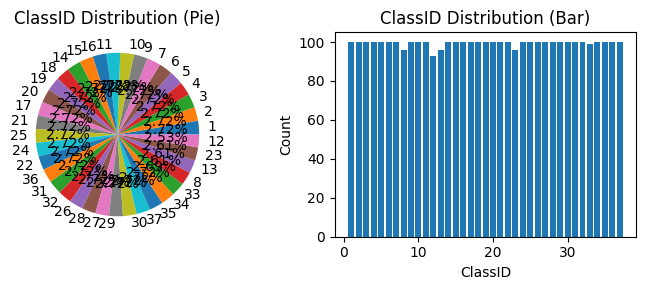

2492 1188


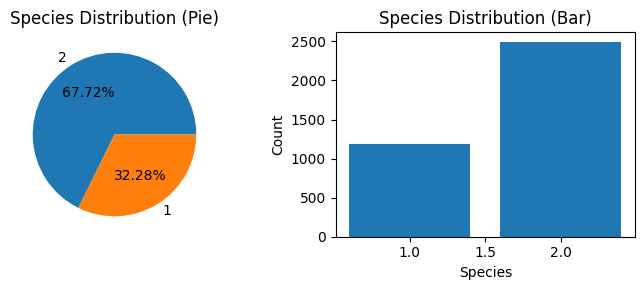

200 200 200 200 200 200 200 200 199 196 196 193 100 100 100 100 100 100 100 100 100 100 100 100 96


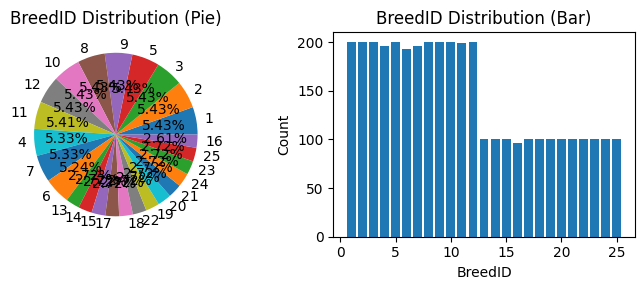

In [ ]:
for column in df_trainval.columns:
    visualize_column_distribution(df_trainval, column)

100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 99 99 99 98 97 89 88


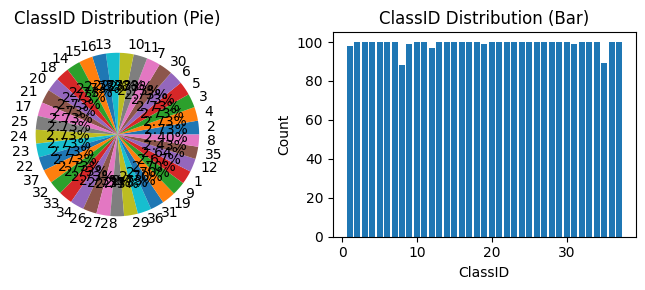

2486 1183


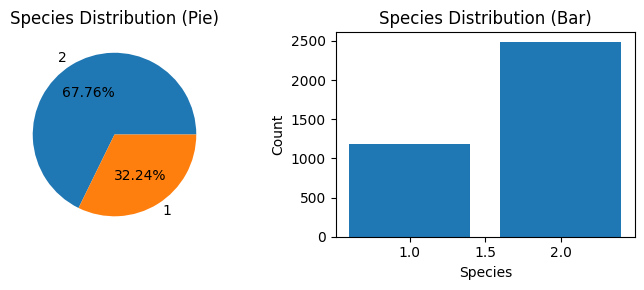

200 200 200 200 200 200 200 200 199 198 197 188 100 100 100 100 100 100 100 100 100 100 99 99 89


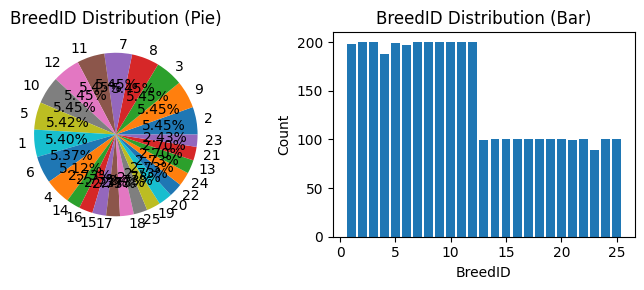

In [ ]:
for column in df_test.columns:
    visualize_column_distribution(df_test, column)

두 데이터셋 모두 고양이와 개가 1:2 비율로 나뉘어져 있으며, class별로 100개씩 존재하는 균형잡힌 데이터이다.

## 이미지 시각화

In [ ]:
# Train과 Validation에 사용될 이미지 파일 이름 리스트 생성
trainval_list = df_trainval['Image'].tolist()

# Test에 사용될 이미지 파일 이름 리스트 생성
test_list = df_test['Image'].tolist()

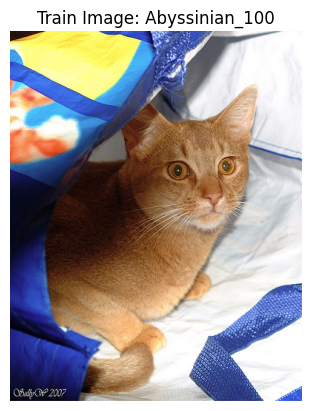

In [ ]:
# Train 데이터에서 예제 이미지 불러오기
train_example_image_name = df_trainval["Image"].iloc[0]
train_image_path = os.path.join(image_dir, f"{train_example_image_name}.jpg")

# 이미지 읽기
train_image = cv2.imread(train_image_path)
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)

# Train 이미지 출력
plt.imshow(train_image)
plt.title(f"Train Image: {train_example_image_name}")
plt.axis("off")
plt.show()

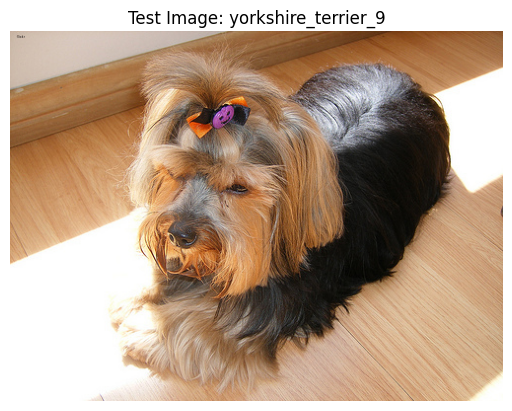

In [ ]:
# Test 데이터에서 예제 이미지 불러오기
test_example_image_name = df_test["Image"].iloc[len(df_test)-1]
test_image_path = os.path.join(image_dir, f"{test_example_image_name}.jpg")

# 이미지 읽기
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Test 이미지 출력
plt.imshow(test_image)
plt.title(f"Test Image: {test_example_image_name}")
plt.axis("off")
plt.show()

강아지들이 귀엽다.

## XML 파일 확인하기

잘 모르기에 Chat GPT의 도움을 받아 진행했다.

In [ ]:
# XML 파일 이름 가져오기 (확장자 제거)
xml_list = [os.path.splitext(file)[0] for file in os.listdir(xml_dir) if file.endswith(".xml")]

# Train 이미지에 대해 XML 파일이 없는 경우 확인
missing_xml = [image for image in trainval_list if image not in xml_list]

# Train 이미지에 대해 XML 파일이 있는 경우 확인
trainval_list = [image for image in trainval_list if image in xml_list]

# 결과 출력
print(f"XML 파일이 없는 Train 이미지 수: {len(missing_xml)}")
print(missing_xml)

# Train 이미지에 대해 XML 파일만 존재하는 경우 확인
extra_xml = [xml for xml in xml_list if xml not in trainval_list]

# 결과 출력
print(f"Train 이미지가 없는 XML 파일 수: {len(extra_xml)}")
print(extra_xml)

XML 파일이 없는 Train 이미지 수: 9
['Abyssinian_104', 'Bengal_111', 'samoyed_10', 'Bengal_175', 'Egyptian_Mau_14', 'Egyptian_Mau_156', 'Egyptian_Mau_186', 'Ragdoll_199', 'saint_bernard_15']
Train 이미지가 없는 XML 파일 수: 15
['Siamese_203', 'newfoundland_155', 'english_cocker_spaniel_162', 'Bombay_189', 'english_cocker_spaniel_163', 'Bombay_192', 'newfoundland_153', 'Bombay_11', 'english_cocker_spaniel_179', 'Egyptian_Mau_129', 'english_cocker_spaniel_164', 'newfoundland_152', 'newfoundland_154', 'Egyptian_Mau_183', 'Bombay_190']


In [ ]:
# Train 데이터와 XML 데이터 매칭
matched_trainval_list = [image for image in trainval_list if image in xml_list]
matched_xml_list = [xml for xml in xml_list if xml in trainval_list]

# 결과 출력
print(f"매칭된 Train 이미지 수: {len(matched_trainval_list)}")
print(f"매칭된 XML 파일 수: {len(matched_xml_list)}")

# 실제로 같은지 확인
if sorted(matched_trainval_list) == sorted(matched_xml_list):
    print("두 리스트는 같은 요소를 가지고 있으며, 순서가 다를 뿐입니다.")
else:
    print("두 리스트의 요소가 다릅니다.")

매칭된 Train 이미지 수: 3671
매칭된 XML 파일 수: 3671
두 리스트는 같은 요소를 가지고 있으며, 순서가 다를 뿐입니다.


이미지와 XML파일의 수가 같아야 학습이 원할하게 진행되므로 일치시켰다.

In [ ]:
# XML 구조 출력 함수 (재귀적 탐색)
def print_all_elements(element, indent=""):
    """
    XML 파일의 모든 태그와 데이터를 출력하는 함수
    - element: 현재 탐색 중인 XML 노드 (Element)
    - indent: 현재 출력의 들여쓰기 (계층 구조 표현)
    """
    print(f"{indent}{element.tag}: {element.text.strip() if element.text else ''}")  # 현재 태그 이름과 데이터 출력
    for child in element:  # 현재 태그의 모든 하위 태그 탐색 (재귀적 탐색)
        print_all_elements(child, indent + "  ")  # 한 단계 들여쓰기 추가하여 출력

# `matched_xml_list`에 포함된 모든 XML 파일을 읽어서 출력
for xml_file in matched_xml_list:
    xml_path = os.path.join(xml_dir, xml_file + ".xml")  # 파일 경로 생성
    if os.path.exists(xml_path):  # 파일 존재 여부 확인
        print(f"파일명: {xml_file}.xml")

        # XML 파일 읽기 및 파싱
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # XML 구조 탐색 및 출력
        print_all_elements(root)
    else:
        print(f"경고: {xml_file}.xml 파일이 존재하지 않습니다!")

    # 처음 파일만 출력
    break

파일명: english_setter_185.xml
annotation: 
  folder: OXIIIT
  filename: english_setter_185.jpg
  source: 
    database: OXFORD-IIIT Pet Dataset
    annotation: OXIIIT
    image: flickr
  size: 
    width: 500
    height: 333
    depth: 3
  segmented: 0
  object: 
    name: dog
    pose: Frontal
    truncated: 0
    occluded: 0
    bndbox: 
      xmin: 59
      ymin: 137
      xmax: 166
      ymax: 222
    difficult: 0


In [ ]:
# XML 파일에서 Bounding Box와 클래스 정보 추출
for obj in root.findall("object"):
    class_name = obj.find("name").text  # 클래스 이름
    bndbox = obj.find("bndbox")
    x_min = int(bndbox.find("xmin").text)
    y_min = int(bndbox.find("ymin").text)
    x_max = int(bndbox.find("xmax").text)
    y_max = int(bndbox.find("ymax").text)

    print(f"Class: {class_name}, Bounding Box: ({x_min}, {y_min}, {x_max}, {y_max})")

    # 처음 원소만 출력
    break

Class: dog, Bounding Box: (59, 137, 166, 222)


In [ ]:
import os
import xml.etree.ElementTree as ET

# 매칭된 XML 파일만 처리
annotations = []

for xml_file in matched_xml_list:  # 매칭된 파일만 불러오기
    xml_path = os.path.join(xml_dir, xml_file + ".xml")  # 확장자 추가

    if os.path.exists(xml_path):  # 파일 존재 여부 확인
        tree = ET.parse(xml_path)
        root = tree.getroot()

        image_name = root.find("filename").text  # 이미지 파일 이름

        for obj in root.findall("object"):
            class_name = obj.find("name").text
            bndbox = obj.find("bndbox")
            x_min = int(bndbox.find("xmin").text)
            y_min = int(bndbox.find("ymin").text)
            x_max = int(bndbox.find("xmax").text)
            y_max = int(bndbox.find("ymax").text)

            annotations.append({
                "image": image_name,
                "class": class_name,
                "bbox": [x_min, y_min, x_max, y_max]
            })
    else:
        print(f"경고: {xml_file}.xml 파일이 존재하지 않습니다!")

# 결과 출력
print(f"총 {len(annotations)}개의 어노테이션이 로드되었습니다.")

총 3672개의 어노테이션이 로드되었습니다.


In [ ]:
annotations[0]

{'image': 'english_setter_185.jpg',
 'class': 'dog',
 'bbox': [59, 137, 166, 222]}

In [ ]:
# XML 파일별 어노테이션 개수 저장
annotation_counts = {}

for xml_file in matched_xml_list:
    xml_path = os.path.join(xml_dir, xml_file + ".xml")
    if os.path.exists(xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()

        object_count = len(root.findall("object"))  # XML 파일 내 객체 개수
        annotation_counts[xml_file] = object_count

# 어노테이션 개수가 2개 이상인 파일 출력
multi_object_files = {k: v for k, v in annotation_counts.items() if v > 1}

if multi_object_files:
    print("📌 객체가 2개 이상 포함된 XML 파일 목록:")
    for file, count in multi_object_files.items():
        print(f"  - {file}: {count}개 객체 포함")
else:
    print("✅ 모든 XML 파일에 1개의 객체만 포함됨.")


📌 객체가 2개 이상 포함된 XML 파일 목록:
  - Bengal_105: 2개 객체 포함


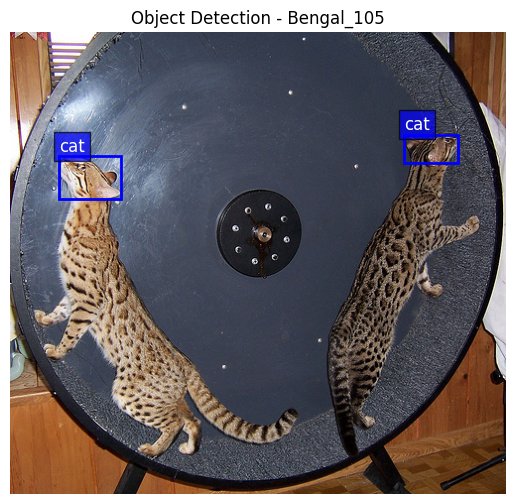

In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 객체가 2개 이상 포함된 XML 파일 선택 (첫 번째 예제)
multi_object_file = list(multi_object_files.keys())[0]  # 첫 번째 XML 파일 선택

# 이미지 파일 경로 설정
image_name = f"{multi_object_file}.jpg"  # XML 파일 이름과 동일한 이미지
image_path = os.path.join(image_dir, image_name)

# XML 파일 경로 설정
xml_path = os.path.join(xml_dir, f"{multi_object_file}.xml")

# 이미지 읽기
train_image = cv2.imread(image_path)
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)

# XML 파일 파싱
tree = ET.parse(xml_path)
root = tree.getroot()

# Bounding Box 정보 추출
bboxes = []
class_names = []

for obj in root.findall("object"):
    class_name = obj.find("name").text  # 클래스 이름
    bndbox = obj.find("bndbox")
    x_min = int(bndbox.find("xmin").text)
    y_min = int(bndbox.find("ymin").text)
    x_max = int(bndbox.find("xmax").text)
    y_max = int(bndbox.find("ymax").text)

    bboxes.append((x_min, y_min, x_max, y_max))
    class_names.append(class_name)

# 시각화 시작
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(train_image)
ax.set_title(f"Object Detection - {multi_object_file}")
ax.axis("off")

# Bounding Box 그리기
for bbox, class_name in zip(bboxes, class_names):
    x_min, y_min, x_max, y_max = bbox
    width = x_max - x_min
    height = y_max - y_min

    # 사각형 그리기
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor="blue", facecolor="none")
    ax.add_patch(rect)

    # 클래스 라벨 표시
    ax.text(x_min, y_min - 5, class_name, color="white", fontsize=12, bbox=dict(facecolor="blue", alpha=0.7))

# 출력
plt.show()

매칭된 리스트의 숫자가 오브젝트의 숫자와 맞지 않아서 확인한 결과, 한 이미지에 두개의 오브젝트가 있었다.

## Object Detection 시각화

Bounding Box: [74, 12, 477, 263]


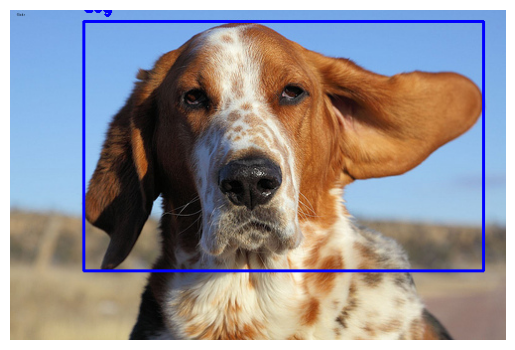

In [ ]:
# Train 데이터에서 예제 이미지 불러오기
train_example_image_name = df_trainval["Image"].iloc[2000]
train_image_path = os.path.join(image_dir, f"{train_example_image_name}.jpg")

# 이미지 읽기
image = cv2.imread(train_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 해당 이미지의 어노테이션 가져오기
annotations = [anno for anno in annotations if anno["image"] == f"{train_example_image_name}.jpg"]

# Bounding Box 그리기
for anno in annotations:
    print(f"Bounding Box: {anno['bbox']}")
    x_min, y_min, x_max, y_max = anno["bbox"]
      # 파란색 박스, 제목
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
    cv2.putText(image, anno["class"], (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

# 시각화
plt.imshow(image)
plt.axis("off")
plt.show()

# 2.데이터로더 만들기

## 트랜스폼

In [ ]:
from torchvision.transforms import v2

class ResizeWithBBox:
    def __init__(self, size=(300, 300)):
        self.size = size

    def __call__(self, image, target=None, *args):
        orig_w, orig_h = image.size  # 원본 이미지 크기
        new_w, new_h = self.size  # 변경할 크기

        # 이미지 Resize
        image = v2.Resize((new_h, new_w))(image)

        # 바운딩 박스 좌표 변환
        if target is not None and "boxes" in target:
            boxes = target["boxes"].clone()
            scale_x = new_w / orig_w
            scale_y = new_h / orig_h

            # x_min, y_min, x_max, y_max에 각각 스케일 적용
            boxes[:, [0, 2]] *= scale_x  # x 좌표 조정
            boxes[:, [1, 3]] *= scale_y  # y 좌표 조정

            target["boxes"] = boxes

        return (image, target) if target is not None else image

# SSD Transform
transform_ssd_train = v2.Compose(
    [
        ResizeWithBBox((300, 300)),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색상 변화
        v2.RandomGrayscale(p=0.1),  # 흑백 변환 (10% 확률)
        v2.RandomInvert(p=0.05),  # 색상 반전 (5% 확률)
        v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # 가우시안 블러
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

transform_ssd_valtest = v2.Compose(
    [
        ResizeWithBBox((300, 300)),
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

## 데이터셋

In [ ]:
from PIL import Image
from torch.utils.data import Dataset

# SSD & YOLO Dataset
class TrainDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, classes, image_list, transforms=None, model_type="SSD"):
        """
        SSD300
        :param image_dir: 이미지 디렉토리 경로
        :param annotation_dir: 어노테이션 디렉토리 경로
        :param classes: 클래스 리스트
        :param image_list: 이미지 파일 이름 리스트
        :param transforms: 데이터 전처리 및 변환
        :param model_type: 모델 타입 (SSD300 또는 YOLOv3)
        """
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.classes = classes
        self.transforms = transforms
        self.image_files = image_list # 확장자 없음
        self.model_type = model_type

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # 이미지, xml 파일 경로 설정
        image_file = self.image_files[idx] + ".jpg"
        annotation_file = self.image_files[idx] + ".xml"
        image_path = os.path.join(self.image_dir, image_file)
        annotation_path = os.path.join(self.annotation_dir, annotation_file)

        # 이미지 로드
        image = Image.open(image_path).convert("RGB")
        orig_w, orig_h = image.size  # 원본 이미지 크기 저장

        # 어노테이션 로드
        boxes = []
        labels = []
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        for obj in root.findall("object"):
            class_name = obj.find("name").text
            if class_name not in self.classes:
                continue
            labels.append(self.classes.index(class_name))

            bndbox = obj.find("bndbox")
            x_min = int(bndbox.find("xmin").text)
            y_min = int(bndbox.find("ymin").text)
            x_max = int(bndbox.find("xmax").text)
            y_max = int(bndbox.find("ymax").text)

            # Bounding Box
            if self.model_type == "SSD":
                # SSD: (xmin, ymin, xmax, ymax)
                boxes.append([x_min, y_min, x_max, y_max])
            else:
                raise ValueError(f"Invalid model type: {self.model_type}")

        # ToTensor
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        # Transform
        if self.transforms:
            transformed = self.transforms(image, target)

            # 변환 결과가 tuple인지 확인 (image, target)
            if isinstance(transformed, tuple):
                image, target = transformed
            else:
                raise RuntimeError("Transforms must return a tuple (image, target)")
        else:
            # 기본 Tensor 변환 (Normalize 없이)
            image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1) / 255.0  # (H, W, C) → (C, H, W)

        return image, target

In [ ]:
class TestDataset(Dataset):
    def __init__(self, image_dir, image_list, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms
        self.image_files = image_list  # 테스트 이미지 리스트 (확장자 없음)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # 이미지 파일 경로
        image_file = self.image_files[idx] + ".jpg"
        image_path = os.path.join(self.image_dir, image_file)

        # 이미지 로드
        image = Image.open(image_path).convert("RGB")

        # Transform 적용
        if self.transforms:
            image = self.transforms(image)

        return image, self.image_files[idx]  # 이미지와 파일 이름 반환

In [ ]:
from sklearn.model_selection import train_test_split

# matched_trainval_list에 해당하는 데이터만 필터링
matched_df = df_trainval[df_trainval['Image'].isin(matched_trainval_list)]

# 이미지와 Species(고양이/개)를 추출
data = matched_df['Image'].tolist()  # 이미지 리스트
labels = matched_df['Species'].tolist()  # Species (1: 고양이, 2: 개)

# Stratified Split 적용 (Species 비율 유지)
train_data, val_data = train_test_split(
    data, test_size=0.2, random_state=42, stratify=labels  # Species 비율 유지
)

# 최종 Train/Validation 리스트 생성
train_list = train_data  # Train 이미지 리스트
val_list = val_data  # Validation 이미지 리스트

# 결과 확인
print(f"Train 이미지 수: {len(train_list)}")
print(f"Validation 이미지 수: {len(val_list)}")
print(f"Test 이미지 수: {len(test_list)}")

Train 이미지 수: 2936
Validation 이미지 수: 735
Test 이미지 수: 3669


## SSD Dataloader

In [ ]:
from torch.utils.data import DataLoader

# 클래스 정의
classes = ["background", "dog", "cat"]

# Train Dataset
train_dataset_ssd = TrainDataset(
    image_dir=image_dir,
    annotation_dir=xml_dir,
    classes=classes,
    image_list=train_list,  # Train 리스트 사용
    transforms=transform_ssd_train,
    model_type="SSD"
)

# Validation Dataset
valid_dataset_ssd = TrainDataset(
    image_dir=image_dir,
    annotation_dir=xml_dir,
    classes=classes,
    image_list=val_list,  # Validation 리스트 사용
    transforms=transform_ssd_valtest,
    model_type="SSD"
)

# Test Dataset 생성
test_dataset_ssd = TestDataset(
    image_dir=image_dir,  # 테스트 이미지 디렉토리
    image_list=test_list,       # 테스트 이미지 리스트 (확장자 없는 이름)
    transforms=transform_ssd_valtest  # 필요하면 Transform 적용
)


# 데이터 로더 생성
trainloader_ssd = DataLoader(train_dataset_ssd, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valloader_ssd = DataLoader(valid_dataset_ssd, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
testloader_ssd = DataLoader(test_dataset_ssd, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# 데이터 크기 출력
print(f"Train 데이터셋 크기: {len(train_dataset_ssd)}")
print(f"Validation 데이터셋 크기: {len(valid_dataset_ssd)}")
print(f"Test 데이터셋 크기: {len(test_dataset_ssd)}")

# 데이터로더 크기 출력
print(f"Train 데이터로더 크기: {len(trainloader_ssd)}")
print(f"Validation 데이터로더 크기: {len(valloader_ssd)}")
print(f"Test 데이터로더 크기: {len(testloader_ssd)}")

Train 데이터셋 크기: 2936
Validation 데이터셋 크기: 735
Test 데이터셋 크기: 3669
Train 데이터로더 크기: 367
Validation 데이터로더 크기: 92
Test 데이터로더 크기: 459


# 3.모델링 준비

## 모델 저장 및 불러오기

GPU가 자꾸 끊겨서 저장하고 불러오는 것이 중요해졌다. CPU로는 한 번 학습하는데에 3시간 30분이 걸린다.

In [ ]:
# 환경설정
if "COLAB_GPU" in os.environ:
    model_dir = "/content/drive/My Drive/model_storage/"
elif os.path.exists("/kaggle"):
    model_dir = "/kaggle/working/model_storage/"
else:
    model_dir = "./model_storage/"

print(f"Now using model_dir: {model_dir}")

# 디렉토리 설정
os.makedirs(model_dir, exist_ok=True)

Now using model_dir: /content/drive/My Drive/model_storage/


In [ ]:
# path 확인하기
def get_checkpoint_path(model_type):
    return os.path.join(model_dir, f"{model_type}_checkpoint.pth")

In [ ]:
# path 저장하기
def save_checkpoint(model, optimizer, scheduler, epoch, best_metric, model_type):
    checkpoint_path = get_checkpoint_path(model_type)
    check_point = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "epoch": epoch + 1,
        "best_metric": best_metric
    }
    torch.save(check_point, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}, Epoch: {epoch + 1}, Best Metric: {best_metric:.4f}")

In [ ]:
# path 불러오기
def load_checkpoint(model, optimizer, scheduler, model_type):
    """
    return: epoch, best_metric
    """
    checkpoint_path = get_checkpoint_path(model_type)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # checkpoint가 없으면 새로 시작
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found: {checkpoint_path}")
        if model_type == "SSD":
            return 0, 0.0
        elif model_type == "YOLO":
            return 0, float("inf")
        else:
            raise ValueError(f"Invalid model type: {model_type}")

    # 체크포인트 불러오기
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint["model"])
    epoch = checkpoint["epoch"]
    best_metric = checkpoint["best_metric"]

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer"])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint["scheduler"])

    print(f"Checkpoint loaded: {checkpoint_path}, Epoch: {epoch}, Best Metric: {best_metric:.4f}")
    return epoch, best_metric

In [ ]:
import torch
import os

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## IOU, AP, mAP, 평가지표 계산기

In [ ]:
import numpy as np
from sklearn.metrics import average_precision_score

def calculate_iou(box, boxes):
    """
    Calculate Intersection over Union (IoU) between a box and multiple boxes.

    Args:
        box (array): Single bounding box [x_min, y_min, x_max, y_max].
        boxes (array): Array of bounding boxes [[x_min, y_min, x_max, y_max], ...].

    Returns:
        array: IoU scores for each box in `boxes`.
    """
    x_min = np.maximum(box[0], boxes[:, 0])
    y_min = np.maximum(box[1], boxes[:, 1])
    x_max = np.minimum(box[2], boxes[:, 2])
    y_max = np.minimum(box[3], boxes[:, 3])

    intersection = np.maximum(0, x_max - x_min) * np.maximum(0, y_max - y_min)
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union = box_area + boxes_area - intersection

    iou = intersection / union
    return iou

In [ ]:
def calculate_ap(predictions, ground_truths, class_idx, iou_threshold=0.5):
    """
    특정 클래스에 대한 AP 계산.
    predictions: 모델의 예측 리스트 [{"boxes": [[x_min, y_min, x_max, y_max]], "labels": [label]}]
    ground_truths: 정답 리스트 [{"boxes": [[x_min, y_min, x_max, y_max]], "labels": [label]}]
    class_idx: 평가 대상 클래스 인덱스
    iou_threshold: IoU 기준값 (default=0.5)

    Returns:
        Average Precision (AP) 값
    """
    true_positives = []
    false_positives = []
    all_ground_truths = 0

    # 모든 예측과 정답을 순회
    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = np.array(pred["boxes"])
        pred_labels = np.array(pred["labels"])
        gt_boxes = np.array(gt["boxes"])
        gt_labels = np.array(gt["labels"])

        # 현재 클래스에 해당하는 박스만 필터링
        pred_boxes = pred_boxes[pred_labels == class_idx]
        gt_boxes = gt_boxes[gt_labels == class_idx]

        all_ground_truths += len(gt_boxes)

        # IoU 계산
        detected = []
        for pred_box in pred_boxes:
            ious = []
            for gt_box in gt_boxes:
                iou = calculate_iou(pred_box, gt_box)
                ious.append(iou)

            if len(ious) > 0:
                max_iou_idx = np.argmax(ious)
                if ious[max_iou_idx] >= iou_threshold and max_iou_idx not in detected:
                    true_positives.append(1)
                    false_positives.append(0)
                    detected.append(max_iou_idx)
                else:
                    true_positives.append(0)
                    false_positives.append(1)
            else:
                false_positives.append(1)

    # Precision-Recall Curve 계산
    tp_cumsum = np.cumsum(true_positives)
    fp_cumsum = np.cumsum(false_positives)
    precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
    recalls = tp_cumsum / (all_ground_truths + 1e-6)

    # AP 계산
    ap = 0.0
    for i in range(1, len(precisions)):
        ap += (recalls[i] - recalls[i - 1]) * precisions[i]

    return ap

In [ ]:
def evaluate_model(predictions, ground_truths, classes):
    class_aps = []

    for class_idx, class_name in enumerate(classes[1:], start=1):
        true_positives = []
        scores = []
        num_ground_truths = 0

        for pred, gt in zip(predictions, ground_truths):
            # Filter for the current class
            pred_boxes = pred["boxes"][pred["labels"] == class_idx].cpu().numpy() if len(pred["boxes"]) > 0 else []
            pred_scores = pred["scores"][pred["labels"] == class_idx].cpu().numpy() if len(pred["scores"]) > 0 else []
            gt_boxes = gt["boxes"][gt["labels"] == class_idx].cpu().numpy() if len(gt["boxes"]) > 0 else []

            num_ground_truths += len(gt_boxes)

            if len(pred_boxes) == 0 or len(gt_boxes) == 0:
                continue  # Skip if no predictions or ground truths for this class

            matched = np.zeros(len(gt_boxes), dtype=bool)
            for box, score in zip(pred_boxes, pred_scores):
                ious = calculate_iou(box, gt_boxes)
                max_iou_idx = np.argmax(ious) if len(ious) > 0 else -1
                max_iou = ious[max_iou_idx] if max_iou_idx >= 0 else 0

                if max_iou >= 0.5 and not matched[max_iou_idx]:
                    true_positives.append(1)
                    matched[max_iou_idx] = True
                else:
                    true_positives.append(0)

                scores.append(score)

        if len(scores) == 0:
            class_aps.append(0)
            continue

        sorted_indices = np.argsort(-np.array(scores))
        true_positives = np.array(true_positives)[sorted_indices]
        scores = np.array(scores)[sorted_indices]

        cum_true_positives = np.cumsum(true_positives)
        precision = cum_true_positives / (np.arange(len(true_positives)) + 1)
        recall = cum_true_positives / num_ground_truths

        ap = average_precision_score(true_positives, scores) if len(scores) > 0 else 0
        class_aps.append(ap)

    mAP = np.mean(class_aps)
    return mAP

## 학습함수

In [ ]:
from tqdm import tqdm # 진행 상황 시각화
import torch

# Training + Validation Loop
def train_model(model, trainloader, valloader, optimizer, scheduler, num_epochs, model_type):
    model.to(device)
    # 체크포인트 불러오기
    start_epoch, best_metric = load_checkpoint(model, optimizer, scheduler, model_type)

    print(f"Start with Epoch={start_epoch}, Best Metric={best_metric}")
    for epoch in range(start_epoch, num_epochs):
        # Training Phase
        model.train()
        total_train_loss = 0

        # 시각화 도구
        train_progress = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")

        for images, targets in train_progress:
            images = [img.to(device) for img in images]

            # SSD / YOLO 분리
            if model_type == "SSD":
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            elif model_type == "YOLO":
                targets = [t.to(device) for t in targets]
            else:
                raise ValueError(f"Invalid model type: {model_type}")

            # Forward pass
            loss_dict = model(images, targets)

            # SSD / YOLO 분리
            if model_type == "SSD":
                losses = sum(loss for loss in loss_dict.values())
            elif model_type == "YOLO":
                loss_coord = loss_dict.get("loss_coord", torch.tensor(0)).to(device)
                loss_conf = loss_dict.get("loss_conf", torch.tensor(0)).to(device)
                loss_cls = loss_dict.get("loss_cls", torch.tensor(0)).to(device)
                losses = loss_coord
            else:
                raise ValueError(f"Invalid model type: {model_type}")

            total_train_loss += losses.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            # Loss 시각화
            if model_type == "SSD":
                train_progress.set_postfix(
                    loc_loss=f"{loss_dict.get('bbox_regression', torch.tensor(0)).item():.4f}",
                    cls_loss=f"{loss_dict.get('classification', torch.tensor(0)).item():.4f}",
                    total_loss=f"{losses.item():.4f}",
                )
            elif model_type == "YOLO":
                train_progress.set_postfix(
                    coord_loss=f"{loss_coord.item():.4f}",
                    conf_loss=f"{loss_conf.item():.4f}",
                    cls_loss=f"{loss_cls.item():.4f}",
                    total_loss=f"{losses.item():.4f}",
                )

        avg_train_loss = total_train_loss / len(trainloader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

        # learning rate check
        if scheduler is not None:
            current_lr = optimizer.param_groups[0]['lr']
            scheduler.step()
            updated_lr = optimizer.param_groups[0]['lr']
            if updated_lr != current_lr:
                print(f"Learning rate updated: {current_lr:.6f} -> {updated_lr:.6f}")

        # Validation Phase
        model.eval()
        all_predictions = []
        all_ground_truths = []

        # 시각화 도구
        val_progress = tqdm(valloader, desc=f"Epoch {epoch+1}/{num_epochs} - Evaluating")

        with torch.no_grad():
            for images, targets in val_progress:
                images = [img.to(device) for img in images]
                predictions = model(images)

                # 저장: 추론 결과와 Ground Truth
                all_predictions.extend(predictions)
                all_ground_truths.extend(targets)

        # 성능 평가 (예: mAP 계산)
        mAP = evaluate_model(all_predictions, all_ground_truths, classes)
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation mAP: {mAP:.4f}\n")

        # mAP 개선된 경우 저장
        if mAP > best_metric:
            print(f"Validation mAP improved from {best_metric:.4f} to {mAP:.4f}")
            best_metric = mAP
            # 체크포인트 저장하기
            save_checkpoint(model, optimizer, scheduler, epoch, best_metric, model_type)

## 시각화 도구

In [ ]:
# SSD 모델 예측 후 박스를 원본 크기 기준으로 변환
def transform_prediction_boxes(predictions, original_size, model_input_size=(300, 300)):
    """
    예측된 바운딩 박스를 원본 이미지 크기로 변환

    Args:
        predictions (list of dict): 모델이 예측한 바운딩 박스 리스트
        original_size (tuple): 원본 이미지 크기 (W, H)
        model_input_size (tuple): 모델의 입력 크기 (기본값 (300, 300))

    Returns:
        list of dict: 원본 이미지 크기로 변환된 바운딩 박스 리스트
    """
    W_orig, H_orig = original_size  # 원본 이미지 크기
    W_model, H_model = model_input_size  # 모델 입력 크기 (기본 300x300)

    scale_x = W_orig / W_model  # x 축 변환 비율
    scale_y = H_orig / H_model  # y 축 변환 비율

    transformed_predictions = []
    for pred in predictions:
        transformed_pred = pred.copy()  # 기존 prediction을 복사하여 변환

        if "boxes" in transformed_pred:
            transformed_pred["boxes"][:, [0, 2]] *= scale_x  # x 좌표 변환
            transformed_pred["boxes"][:, [1, 3]] *= scale_y  # y 좌표 변환

        transformed_predictions.append(transformed_pred)

    return transformed_predictions



# 정답 바운딩 박스 시각화
def visualize_boxes(image, ground_truth, prediction, classes, image_size=None):
    """
    Args:
        image (torch.Tensor): 입력 이미지 (C, H, W 형식).
        ground_truth (dict): Ground Truth 바운딩 박스 정보 (boxes, labels 포함).
        prediction (dict): 모델의 예측 박스 정보 (boxes, labels, scores 포함).
        classes (list): 클래스 이름 리스트.
        image_size (tuple): 원본 이미지 크기 (W, H) → 정규화된 좌표를 복원할 때 필요
    """
    # 정규화 해제
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()

    image = image * std + mean
    image = np.clip(image, 0, 1)

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    # 이미지 크기 확인 (W, H)
    if image_size:
        W, H = image_size
    else:
        H, W = image.shape[:2]  # (H, W, C)에서 크기 추출

    # 정답 바운딩 박스 (파란색)
    for box, label in zip(ground_truth["boxes"], ground_truth["labels"]):
        if box.max() <= 1.0:  # 정규화된 좌표라면 변환
            x_min, y_min, x_max, y_max = (box * torch.tensor([W, H, W, H])).tolist()
        else:
            x_min, y_min, x_max, y_max = box.tolist()

        width, height = x_max - x_min, y_max - y_min
        class_name = classes[label] if 0 <= label < len(classes) else f"Unknown({label})"

        rect = patches.Rectangle(
            (x_min, y_min), width, height, linewidth=2, edgecolor="blue", facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(
            x_min,
            max(y_min - 10, 0),
            f"GT: {class_name}",
            color="blue",
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.7),
        )

    # 예측 바운딩 박스 (빨간색)
    for box, label, score in zip(prediction["boxes"], prediction["labels"], prediction["scores"]):
        if score < 0.5:  # Confidence Score가 낮으면 스킵
            continue

        if box.max() <= 1.0:  # 정규화된 좌표라면 변환
            x_min, y_min, x_max, y_max = (box * torch.tensor([W, H, W, H])).tolist()
        else:
            x_min, y_min, x_max, y_max = box.tolist()

        width, height = x_max - x_min, y_max - y_min
        class_name = classes[label] if 0 <= label < len(classes) else f"Unknown({label})"

        rect = patches.Rectangle(
            (x_min, y_min), width, height, linewidth=2, edgecolor="red", facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(
            x_min,
            max(y_min - 10, 0),
            f"Pred: {class_name} ({score:.2f})",
            color="red",
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.7),
        )

    plt.axis("off")
    plt.show()

In [ ]:
# 예측 바운딩 박스 시각화
def visualize_prediction(image, prediction, classes, threshold=0.5):
    """
    Args:
        image (torch.Tensor): 추론에 사용된 이미지 (C, H, W 형식).
        prediction (dict): 모델의 예측 결과 (boxes, labels, scores 포함).
        classes (list): 클래스 이름 리스트.
    """
    # 정규화 해제
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)

    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu()  # (C, H, W) → (H, W, C)
        image = image * std + mean  # 정규화 해제
        image = torch.clamp(image, 0, 1).numpy()  # 값 범위를 [0,1]로 조정 후 NumPy 변환

    # 이미지 시각화
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    # Bounding Box와 클래스 이름 시각화
    for box, label, score in zip(prediction["boxes"], prediction["labels"], prediction["scores"]):
        if score > threshold:  # Confidence Score 임계값 적용
            x_min, y_min, x_max, y_max = box.tolist()
            width, height = x_max - x_min, y_max - y_min

            # 유효 라벨 확인
            if 0 <= label < len(classes):
                class_name = classes[label]
            else:
                class_name = f"Unknown({label})"

            # Bounding Box 추가 (빨간색)
            rect = patches.Rectangle(
                (x_min, y_min), width, height, linewidth=2, edgecolor="red", facecolor="none"
            )
            ax.add_patch(rect)

            # 클래스 이름과 Confidence Score 추가
            ax.text(
                x_min,
                max(y_min - 10, 0),
                f"{class_name}: {score:.2f}",
                color="red",
                fontsize=10,
                bbox=dict(facecolor="white", alpha=0.7),
            )

    plt.axis("off")
    plt.show()

# 4.모델 학습 및 평가 시각화

## SSD300

In [ ]:
from torchvision.models import resnet34
from torchvision.models.detection import ssd
from torchvision.models.detection.anchor_utils import DefaultBoxGenerator

# 클래스 개수
num_classes = len(classes)  # background 포함

# ResNet34 백본
backbone_base = resnet34(weights="ResNet34_Weights.IMAGENET1K_V1")
backbone = torch.nn.Sequential(*list(backbone_base.children())[:-2])
backbone.out_channels = [512, 1024, 512, 256, 256, 256]

# 앵커박스
anchor_generator = DefaultBoxGenerator(
    aspect_ratios=[[2], [2, 3], [2, 3], [2, 3], [2, 3], [2]],
    scales=[0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05],
    steps=[8, 16, 32, 64, 100, 300]
)

# SSD300 모델
ssd_model = ssd.SSD(
    backbone=backbone,
    num_classes=num_classes,
    anchor_generator=anchor_generator,
    size=(300, 300)
)

# 디바이스 설정
ssd_model = ssd_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 113MB/s]


In [ ]:
print(ssd_model)

SSD(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

num_classes=3으로 적용되었다.

In [ ]:
import torch
from torchvision.transforms import functional as F

# Optimizer와 Loss 정의
ssd_optimizer = torch.optim.SGD(ssd_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
ssd_lr_scheduler = torch.optim.lr_scheduler.CyclicLR(ssd_optimizer, base_lr=0.00005, step_size_up=6, max_lr=0.001, gamma=0.75, mode='exp_range')
ssd_num_epochs = 30

train_model(ssd_model, trainloader_ssd, valloader_ssd, ssd_optimizer, ssd_lr_scheduler, ssd_num_epochs, "SSD")

Checkpoint loaded: /content/drive/My Drive/model_storage/SSD_checkpoint.pth, Epoch: 23, Best Metric: 0.9775
Start with Epoch=23, Best Metric=0.9775033798835402


Epoch 24/30 - Training: 100%|██████████| 367/367 [01:52<00:00,  3.27it/s, cls_loss=0.1051, loc_loss=0.5064, total_loss=0.6115]


Epoch 24/30, Train Loss: 0.8750
Learning rate updated: 0.000050 -> 0.000050


Epoch 24/30 - Evaluating: 100%|██████████| 92/92 [00:09<00:00,  9.75it/s]


Epoch 24/30, Validation mAP: 0.9733



Epoch 25/30 - Training: 100%|██████████| 367/367 [01:49<00:00,  3.36it/s, cls_loss=0.2077, loc_loss=0.3630, total_loss=0.5707]


Epoch 25/30, Train Loss: 0.8647
Learning rate updated: 0.000050 -> 0.000050


Epoch 25/30 - Evaluating: 100%|██████████| 92/92 [00:09<00:00,  9.49it/s]


Epoch 25/30, Validation mAP: 0.9701



Epoch 26/30 - Training: 100%|██████████| 367/367 [01:47<00:00,  3.41it/s, cls_loss=0.1875, loc_loss=0.6068, total_loss=0.7943]


Epoch 26/30, Train Loss: 0.8290
Learning rate updated: 0.000050 -> 0.000050


Epoch 26/30 - Evaluating: 100%|██████████| 92/92 [00:09<00:00,  9.77it/s]


Epoch 26/30, Validation mAP: 0.9712



Epoch 27/30 - Training: 100%|██████████| 367/367 [01:46<00:00,  3.44it/s, cls_loss=0.1108, loc_loss=0.5004, total_loss=0.6112]


Epoch 27/30, Train Loss: 0.8487
Learning rate updated: 0.000050 -> 0.000050


Epoch 27/30 - Evaluating: 100%|██████████| 92/92 [00:09<00:00,  9.73it/s]


Epoch 27/30, Validation mAP: 0.9754



Epoch 28/30 - Training: 100%|██████████| 367/367 [01:45<00:00,  3.47it/s, cls_loss=0.0385, loc_loss=0.2501, total_loss=0.2886]


Epoch 28/30, Train Loss: 0.7527


Epoch 28/30 - Evaluating: 100%|██████████| 92/92 [00:10<00:00,  8.71it/s]


Epoch 28/30, Validation mAP: 0.9729



Epoch 29/30 - Training: 100%|██████████| 367/367 [01:45<00:00,  3.48it/s, cls_loss=0.1129, loc_loss=1.8263, total_loss=1.9392]


Epoch 29/30, Train Loss: 0.8018
Learning rate updated: 0.000050 -> 0.000050


Epoch 29/30 - Evaluating: 100%|██████████| 92/92 [00:10<00:00,  8.75it/s]


Epoch 29/30, Validation mAP: 0.9706



Epoch 30/30 - Training: 100%|██████████| 367/367 [01:45<00:00,  3.49it/s, cls_loss=0.2370, loc_loss=0.3973, total_loss=0.6343]


Epoch 30/30, Train Loss: 0.7419
Learning rate updated: 0.000050 -> 0.000050


Epoch 30/30 - Evaluating: 100%|██████████| 92/92 [00:10<00:00,  8.91it/s]


Epoch 30/30, Validation mAP: 0.9767



In [ ]:
_, _= load_checkpoint(ssd_model, None, None, "SSD")
ssd_model.eval()

# 결과 저장 리스트
all_val_samples = []

# 검증데이터 시각화
with torch.no_grad():
    for images, targets in tqdm(valloader_ssd, desc="Validation Inference"):
        images = [img.to(device) for img in images]
        predictions = ssd_model(images)

        # 예측값이 없는 경우 제외
        if not predictions or len(predictions) != len(images):
            print("Skipping empty predictions")
            continue

        for img, pred, target in zip(images, predictions, targets):
            # 박스가 비어있으면 제외
            if "boxes" not in pred or len(pred["boxes"]) == 0:
                print("No bounding boxes found")
                continue

            # 모델이 예측한 박스를 원본 크기로 변환
            pred = transform_prediction_boxes([pred], original_size=(img.shape[2], img.shape[1]))[0]

            # 샘플 이미지 저장
            all_val_samples.append((img.cpu(), target, pred))

Checkpoint loaded: /content/drive/My Drive/model_storage/SSD_checkpoint.pth, Epoch: 23, Best Metric: 0.9775


Validation Inference:   7%|▋         | 6/92 [00:00<00:10,  8.44it/s]

No bounding boxes found


Validation Inference:  33%|███▎      | 30/92 [00:03<00:07,  8.35it/s]

No bounding boxes found


Validation Inference:  41%|████▏     | 38/92 [00:04<00:06,  8.73it/s]

No bounding boxes found


Validation Inference:  46%|████▌     | 42/92 [00:05<00:07,  6.79it/s]

No bounding boxes found


Validation Inference:  59%|█████▊    | 54/92 [00:06<00:06,  6.13it/s]

No bounding boxes found


Validation Inference:  63%|██████▎   | 58/92 [00:07<00:05,  6.20it/s]

No bounding boxes found


Validation Inference:  65%|██████▌   | 60/92 [00:07<00:04,  7.03it/s]

No bounding boxes found


Validation Inference:  72%|███████▏  | 66/92 [00:08<00:03,  8.36it/s]

No bounding boxes found


Validation Inference:  76%|███████▌  | 70/92 [00:09<00:02,  8.50it/s]

No bounding boxes found


Validation Inference:  93%|█████████▎| 86/92 [00:10<00:00,  8.31it/s]

No bounding boxes found


Validation Inference:  96%|█████████▌| 88/92 [00:11<00:00,  8.54it/s]

No bounding boxes found


Validation Inference: 100%|██████████| 92/92 [00:11<00:00,  7.94it/s]

No bounding boxes found


In [ ]:
# 최대 시각화 개수 설정
max_visualizations = 10

# 최대 시각화 개수만큼 선택
selected_val_samples = random.sample(all_val_samples, min(max_visualizations, len(all_val_samples)))

for img, target, pred in selected_val_samples:
    # GT 박스와 예측 박스를 한 이미지에 시각화
    visualize_boxes(img, target, pred, classes, image_size=(img.shape[2], img.shape[1]))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
_, _= load_checkpoint(ssd_model, None, None, "SSD")
ssd_model.eval()

all_test_samples = []

# 시험 데이터 시각화
with torch.no_grad():
    for images, image_files in tqdm(testloader_ssd, desc="Test Inference"):
        images = [img.to(device) for img in images]
        predictions = ssd_model(images)

        # predictions이 비어있으면 예외
        if not predictions or len(predictions) != len(images):
            print(f"Skipping empty predictions for {image_files}")
            continue

        for img, pred, file_name in zip(images, predictions, image_files):
            # 박스가 없으면 스킵
            if "boxes" not in pred or len(pred["boxes"]) == 0:
                print(f"No bounding boxes found in {file_name}")
                continue

            all_test_samples.append((img.cpu(), pred, file_name))

Checkpoint loaded: /content/drive/My Drive/model_storage/SSD_checkpoint.pth, Epoch: 23, Best Metric: 0.9775


Test Inference:   3%|▎         | 14/459 [00:01<00:52,  8.50it/s]

No bounding boxes found in american_bulldog_207
No bounding boxes found in american_bulldog_220


Test Inference:   7%|▋         | 32/459 [00:04<01:06,  6.38it/s]

No bounding boxes found in american_pit_bull_terrier_47
No bounding boxes found in american_pit_bull_terrier_52


Test Inference:   7%|▋         | 34/459 [00:04<01:05,  6.51it/s]

No bounding boxes found in american_pit_bull_terrier_66
No bounding boxes found in american_pit_bull_terrier_70


Test Inference:   8%|▊         | 38/459 [00:05<01:08,  6.17it/s]

No bounding boxes found in american_pit_bull_terrier_93


Test Inference:  10%|█         | 47/459 [00:06<00:52,  7.83it/s]

No bounding boxes found in basset_hound_6


Test Inference:  12%|█▏        | 53/459 [00:07<00:47,  8.54it/s]

No bounding boxes found in beagle_23


Test Inference:  12%|█▏        | 55/459 [00:07<00:47,  8.59it/s]

No bounding boxes found in beagle_3


Test Inference:  13%|█▎        | 60/459 [00:07<00:45,  8.76it/s]

No bounding boxes found in beagle_74
No bounding boxes found in beagle_75
No bounding boxes found in beagle_83


Test Inference:  14%|█▎        | 62/459 [00:08<00:45,  8.73it/s]

No bounding boxes found in beagle_8
No bounding boxes found in beagle_97


Test Inference:  14%|█▍        | 64/459 [00:08<00:44,  8.94it/s]

No bounding boxes found in beagle_9


Test Inference:  15%|█▍        | 67/459 [00:08<00:45,  8.64it/s]

No bounding boxes found in Bengal_34


Test Inference:  16%|█▌        | 73/459 [00:09<00:44,  8.64it/s]

No bounding boxes found in Bengal_7
No bounding boxes found in Bengal_84


Test Inference:  22%|██▏       | 99/459 [00:12<00:40,  8.98it/s]

No bounding boxes found in Bombay_90


Test Inference:  22%|██▏       | 103/459 [00:12<00:43,  8.21it/s]

No bounding boxes found in boxer_2


Test Inference:  23%|██▎       | 105/459 [00:12<00:41,  8.47it/s]

No bounding boxes found in boxer_4


Test Inference:  23%|██▎       | 107/459 [00:13<00:41,  8.58it/s]

No bounding boxes found in boxer_60


Test Inference:  26%|██▌       | 120/459 [00:14<00:38,  8.76it/s]

No bounding boxes found in British_Shorthair_58


Test Inference:  28%|██▊       | 127/459 [00:15<00:36,  9.02it/s]

No bounding boxes found in chihuahua_2


Test Inference:  30%|██▉       | 136/459 [00:16<00:48,  6.73it/s]

No bounding boxes found in chihuahua_95


Test Inference:  31%|███       | 142/459 [00:17<00:45,  6.92it/s]

No bounding boxes found in Egyptian_Mau_44


Test Inference:  34%|███▍      | 158/459 [00:19<00:36,  8.30it/s]

No bounding boxes found in english_cocker_spaniel_6
No bounding boxes found in english_cocker_spaniel_80


Test Inference:  43%|████▎     | 196/459 [00:24<00:29,  8.79it/s]

No bounding boxes found in great_pyrenees_78


Test Inference:  44%|████▍     | 201/459 [00:24<00:29,  8.83it/s]

No bounding boxes found in havanese_25


Test Inference:  45%|████▍     | 205/459 [00:25<00:28,  8.85it/s]

No bounding boxes found in havanese_51


Test Inference:  45%|████▌     | 208/459 [00:25<00:28,  8.89it/s]

No bounding boxes found in havanese_72
No bounding boxes found in havanese_80


Test Inference:  47%|████▋     | 216/459 [00:26<00:27,  8.87it/s]

No bounding boxes found in japanese_chin_42


Test Inference:  52%|█████▏    | 240/459 [00:29<00:31,  6.91it/s]

No bounding boxes found in leonberger_37


Test Inference:  57%|█████▋    | 263/459 [00:32<00:22,  8.73it/s]

No bounding boxes found in miniature_pinscher_19


Test Inference:  58%|█████▊    | 265/459 [00:32<00:22,  8.79it/s]

No bounding boxes found in miniature_pinscher_37


Test Inference:  58%|█████▊    | 268/459 [00:33<00:22,  8.64it/s]

No bounding boxes found in miniature_pinscher_53


Test Inference:  59%|█████▉    | 272/459 [00:33<00:21,  8.72it/s]

No bounding boxes found in miniature_pinscher_82


Test Inference:  61%|██████    | 280/459 [00:34<00:20,  8.65it/s]

No bounding boxes found in newfoundland_54
No bounding boxes found in newfoundland_5


Test Inference:  62%|██████▏   | 286/459 [00:35<00:19,  8.78it/s]

No bounding boxes found in newfoundland_98
No bounding boxes found in Persian_21


Test Inference:  63%|██████▎   | 290/459 [00:35<00:18,  9.12it/s]

No bounding boxes found in Persian_273


Test Inference:  64%|██████▎   | 292/459 [00:35<00:18,  8.80it/s]

No bounding boxes found in Persian_41


Test Inference:  65%|██████▍   | 298/459 [00:36<00:17,  9.05it/s]

No bounding boxes found in Persian_98
No bounding boxes found in Persian_9


Test Inference:  69%|██████▉   | 316/459 [00:38<00:15,  9.04it/s]

No bounding boxes found in pug_43


Test Inference:  70%|██████▉   | 321/459 [00:39<00:15,  8.64it/s]

No bounding boxes found in pug_77
No bounding boxes found in pug_84
No bounding boxes found in pug_85


Test Inference:  71%|███████   | 325/459 [00:39<00:13,  9.80it/s]

No bounding boxes found in pug_99


Test Inference:  72%|███████▏  | 332/459 [00:40<00:14,  9.00it/s]

No bounding boxes found in Ragdoll_62


Test Inference:  73%|███████▎  | 335/459 [00:40<00:13,  8.96it/s]

No bounding boxes found in Ragdoll_91


Test Inference:  77%|███████▋  | 355/459 [00:43<00:16,  6.23it/s]

No bounding boxes found in saint_bernard_51


Test Inference:  81%|████████▏ | 374/459 [00:46<00:10,  8.41it/s]

No bounding boxes found in scottish_terrier_193
No bounding boxes found in scottish_terrier_199


Test Inference:  82%|████████▏ | 378/459 [00:46<00:09,  8.44it/s]

No bounding boxes found in scottish_terrier_41


Test Inference:  83%|████████▎ | 383/459 [00:47<00:08,  8.67it/s]

No bounding boxes found in scottish_terrier_73


Test Inference:  91%|█████████ | 417/459 [00:50<00:04,  8.99it/s]

No bounding boxes found in Sphynx_37


Test Inference:  92%|█████████▏| 421/459 [00:51<00:04,  8.81it/s]

No bounding boxes found in Sphynx_74
No bounding boxes found in Sphynx_87


Test Inference:  93%|█████████▎| 427/459 [00:52<00:03,  8.70it/s]

No bounding boxes found in staffordshire_bull_terrier_42


Test Inference:  95%|█████████▌| 437/459 [00:53<00:02,  8.91it/s]

No bounding boxes found in wheaten_terrier_23
No bounding boxes found in wheaten_terrier_25
No bounding boxes found in wheaten_terrier_30


Test Inference:  96%|█████████▌| 441/459 [00:53<00:02,  8.70it/s]

No bounding boxes found in wheaten_terrier_4
No bounding boxes found in wheaten_terrier_53


Test Inference:  98%|█████████▊| 449/459 [00:54<00:01,  8.61it/s]

No bounding boxes found in yorkshire_terrier_20
No bounding boxes found in yorkshire_terrier_29


Test Inference:  98%|█████████▊| 452/459 [00:54<00:00,  8.74it/s]

No bounding boxes found in yorkshire_terrier_42


Test Inference:  99%|█████████▉| 454/459 [00:55<00:00,  8.04it/s]

No bounding boxes found in yorkshire_terrier_55
No bounding boxes found in yorkshire_terrier_59
No bounding boxes found in yorkshire_terrier_60


Test Inference:  99%|█████████▉| 456/459 [00:55<00:00,  7.09it/s]

No bounding boxes found in yorkshire_terrier_67
No bounding boxes found in yorkshire_terrier_68
No bounding boxes found in yorkshire_terrier_69


Test Inference: 100%|█████████▉| 458/459 [00:55<00:00,  6.61it/s]

No bounding boxes found in yorkshire_terrier_87
No bounding boxes found in yorkshire_terrier_89
No bounding boxes found in yorkshire_terrier_93


Test Inference: 100%|██████████| 459/459 [00:55<00:00,  8.20it/s]

No bounding boxes found in yorkshire_terrier_9


In [ ]:
# 최대 시각화 개수 설정
max_visualizations = 20

# 최대 시각화 개수만큼 선택
selected_test_samples = random.sample(all_test_samples, min(max_visualizations, len(all_test_samples)))

for img, pred, file_name in selected_test_samples:
    print(f"파일 이름: {file_name}")
    visualize_prediction(img, pred, classes)

Output hidden; open in https://colab.research.google.com to view.